# Мобильные приложения — Выделение групп пользователей на основе поведения

**Задача проекта:** -Выделить группы пользователей на основе поведения

**Кто заинтересован в результате вашей работы?** Как мне кажется это достаточно типичная задача продуктового аналитика - классифицировать пользователей и понять, какие группы самые прибыльные для бизнеса. То есть заинтересован заказчик - владелец нашего продукта - мобильного приложения. 

**Какие решения будут предприняты на основании вашего анализа?** - решение о том через какие каналы привлекать пользователей (на основании проверки гипотез : Привлеченные по ссылке из yandex и по ссылке из google демонстрируют разную конверсию в просмотры контактов, пользователи с событием tips_click(пользователь кликнул по рекомендованному объявлению) и пользователи, использовавшие поиск search монстрируют разную конверсию в просмотры контактов

**Этапы проекта**

1. Знакомство с данными загрузка данных, описание полей данных
2. Предобработка данных 
    - Приведение полей к формату стиля snake_case и переименование в интуитивно понятные, если необходимо
    - Определение наличия пропущенных значений и работа с ними
    - Определение наличия дубликатов и работа с дубликатами
    - Приведение к определенным типам данных в случае несоответствия типов
3. Исследовательский анализ данных (EDA)
    - посмотреть какие события есть в датасете, как часто они встречаются
    - посмотреть сколько пользователей совершали каждое из этих событий
    - посмотреть в каком порядке происходят события, все ли они выстраиваются в последовательную цепочку
    - рассчитать retention rate
    - расчет метрики время, проведённого в приложении
    - расчет метрики частота действий пользователя 
    - расчет конверсии в целевое действие — просмотр контактов
4. Сегментирование пользователей 
    - разделение пользователей на группы используя кластерный анализ
    - анализ retention rate по группам
4. Проверка статистических гипотез
    - Проверка гипотезы: привлеченные по ссылке из yandex и по ссылке из google демонстрируют разную конверсию в просмотры контактов
    - Проверка гипотезы: пользователи с событием tips_click(пользователь кликнул по рекомендованному объявлению) и пользователи, использовавшие поиск search монстрируют разную конверсию в добавление объявления в избранное
5. Выводы и рекомендации
6. Создание дашборда и презентации

## Импорт библиотек

In [1]:
import pandas as pd
from scipy import stats as st
import math as mth
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
import datetime
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Задание пользовательских функций

In [2]:
def week_start(date):
    """
    Возвращает лайфтайм
    по значению даты первого 
    события пользователя 
    """
    if date <=  datetime.date(2019, 10, 13):
        return datetime.date(2019, 10, 7)
    elif date > datetime.date(2019, 10, 13) and date <= datetime.date(2019, 10, 20) :
        return datetime.date(2019, 10, 14)
    elif date > datetime.date(2019, 10, 20) and date <= datetime.date(2019, 10, 27) :
        return datetime.date(2019, 10, 21)
    else: return datetime.date(2019, 10, 28)

In [3]:
def get_retention(df):
    
    # 
    df['week_start'] = df['event_time_first'].dt.isocalendar().week 
    df['week'] = df['event_time'].dt.isocalendar().week 
    df['lifetime'] = (df['week'] - df['event_time_first'].dt.isocalendar().week )

    df['week_start_date'] = df['event_time_first'].apply(week_start)
    result_grouped = df.pivot_table(
    index=['week_start_date'], columns='lifetime', values='user_id', aggfunc='nunique')
    
    cohort_sizes = (
    df.groupby('week_start_date')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'}))
    
    result_grouped = cohort_sizes.merge(
    result_grouped, on='week_start_date', how='left').fillna(0)
    
    result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0).drop(columns=['cohort_size'])
    
    return result_grouped

In [4]:
def z_test(purchases, leads, alpha = 0.05):
    # функция z-критерия проверки гипотез
    p1 = purchases[0]/leads[0] # ваш код
    p2 = purchases[1]/leads[1] 
    p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1])) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha: # ваш код
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' )

## Загрузка и обзор данных

У нас есть два датасета : **mobile_dataset** и **mobile_sourсes**. Посмотрим на данные

In [5]:
dataset = pd.read_csv('mobile_dataset.csv')
sources = pd.read_csv('mobile_sourсes.csv')

### Датасет dataset

Изучим датасет dataset

In [6]:
dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


В датасете **dataset** 3 поля и 74197 строк, судя по info пропущенных значений полей нет. В полях содержится следующая информация:

1. **event.time** - время совершения события, формат object
2. **event.name** - название события, формат object
3. **user.id** - идентификатор пользователя, формат object


### Датасет sources

Изучим датасет sources

In [8]:
sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [9]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


В датасете **sources** 2 поля и 4293  строк, судя по info пропущенных значений полей нет. В полях содержится следующая информация:
1. **userId** - идентификатор пользователя, формат object
2. **source** - источник, с которого пользователь установил приложение, формат object

Расшифровки событий dataset:
- **advert_open**  — открытие карточки объявления
- **photos_show**  — просмотр фотографий в объявлении
- **tips_show**  — пользователь увидел рекомендованные объявления
- **tips_click**  — пользователь кликнул по рекомендованному объявлению
- **contacts_show  и  show_contacts**  — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- **contacts_call**  — пользователь позвонил по номеру телефона на карточке объявления
- **map**  — пользователь открыл карту размещенных объявлений
- **search_1  —  search_7**  — разные события, связанные с поиском по сайту
- **favorites_add**  — добавление объявления в избранное

В датасетах уже заметны некоторые проблемы: неправильный формат даты dataset, названия полей, неприведенные к силю snake_case. Разберемся с ними в предобработке

## Предобработка данных

### Изменение названия полей

В столбце датасет для приведения к формату snake_case изменим точку на нижнее подчеркивание

In [10]:
dataset.columns= dataset.columns.str.replace('.', '_')
dataset.columns

Index(['event_time', 'event_name', 'user_id'], dtype='object')

Для датасета sourse приведем к snake_case поле userId 

In [11]:
sources = sources.rename(columns={'userId':'user_id'})
sources.columns

Index(['user_id', 'source'], dtype='object')

### Проверка на пропуски и дубликаты

In [12]:
sources.name = 'sources'
dataset.name = 'dataset'

In [13]:
for i in [dataset, sources]:
    name = i.name
    print(f'Количество пропусков в датасете {name} равно:')
    print(i.isna().sum())
    print(f'Количество дубликатов в датасете {name} равно: {i.duplicated().sum()}')
    print()

Количество пропусков в датасете dataset равно:
event_time    0
event_name    0
user_id       0
dtype: int64
Количество дубликатов в датасете dataset равно: 0

Количество пропусков в датасете sources равно:
user_id    0
source     0
dtype: int64
Количество дубликатов в датасете sources равно: 0



Пропусков и явных дубликатов нет

### Изменение типов данных

Для дальнейшей работы необходимо привести столбец event_time к формату datetime. Также округлим данный датасет до секунд, для того чтобы придать некоторую "дискретность" и для более краткой записи

In [14]:
dataset['event_time'] = pd.to_datetime(dataset['event_time']).dt.round('s')
dataset['event_time'].head()

0   2019-10-07 00:00:00
1   2019-10-07 00:00:01
2   2019-10-07 00:00:02
3   2019-10-07 00:00:07
4   2019-10-07 00:00:56
Name: event_time, dtype: datetime64[ns]

### Работа со значениями event_name

In [15]:
dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Наибольшее количество событий - tips_show -  пользователь увидел рекомендованные объявления
Объеденим события contacts_show  и show_contacts  тк это одно событие - пользователь нажал на кнопку "посмотреть номер
телефона" на карточке объявления.

Также объеденим все события  search. Так как у нас нет интерпретации того, как данные поиски по сайту категоризовались, в рамках данного исследования будем рассматривать их вместе как событие search - поиск по сайту.

In [16]:
# замена show_contacts на contacts_show
dataset['event_name']=dataset['event_name'].replace('show_contacts', 'contacts_show')
dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64

In [17]:
# приведение всех поисков к одному виду 
searches = dataset.loc[dataset['event_name'].str.contains("search", case=False)]['event_name'].index
dataset.loc[searches,'event_name'] = 'search'
dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

### Объединение датафреймов

Создадим общий датафрейм для удобства последующего анализа

In [18]:
df = dataset.merge(sources, on='user_id')
df.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other


### Вывод
В ходе предобработки данных были сделаны следующие процедуры:
1. Названия полей датафреймов приведены к стилю snake_case
2. Данные были проверены на пропуски и дубликаты
3. Поле с датой было приведено к необходимому формату
4. Из столбца с событиями были убраны неявные дубликаты
5. Данные были объединены для последующей работы

## Исследовательский анализ данных (EDA)

### Retention rate

In [19]:
print('Минимальная дата в датасете', df['event_time'].min())
print('Максимальная дата в датасете', df['event_time'].max())

Минимальная дата в датасете 2019-10-07 00:00:00
Максимальная дата в датасете 2019-11-03 23:58:13


In [20]:
# добавление поле даты без времени
df['date'] = df['event_time'].dt.date
df.head()

,event_time,event_name,user_id,source,date
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07


Добавим дату и время первого события к нашему датафрейму

In [21]:
# дата и время первого и последнего действия, совершенного пользователем

first_event = df.groupby('user_id').agg({'event_time': 'min'}).reset_index()
first_event.head()

,user_id,event_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41


In [22]:
last_event = df.groupby('user_id').agg({'event_time': 'max'}).reset_index()
last_event.head()

,user_id,event_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22 11:30:53
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03 17:12:10
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 14:19:18
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-31 21:42:16
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-29 02:17:12


In [23]:
df = df.merge(first_event, on='user_id', suffixes=('', '_first'))
df.head()

,event_time,event_name,user_id,source,date,event_time_first
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07


In [24]:
df = df.merge(last_event, on='user_id', suffixes=('', '_last'))
df.tail()

,event_time,event_name,user_id,source,date,event_time_first,event_time_last
74192,2019-11-03 23:46:47,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03,2019-11-03 23:46:47,2019-11-03 23:47:50
74193,2019-11-03 23:46:59,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03,2019-11-03 23:46:47,2019-11-03 23:47:50
74194,2019-11-03 23:47:01,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03,2019-11-03 23:46:47,2019-11-03 23:47:50
74195,2019-11-03 23:47:47,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03,2019-11-03 23:46:47,2019-11-03 23:47:50
74196,2019-11-03 23:47:50,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03,2019-11-03 23:46:47,2019-11-03 23:47:50


Поскольку мы располагаем данными меньше чем за месяц, а также наше приложение - приложение по типу "авито", где не важен показатель суточной активности, а важно смотреть на поведение пользователей через какое-то время, было принято решение рассматривать когорты по неделям. 
Таким образом:
1. когорта 1:  7 -13 октября
2. когорта 2:  14 - 20 октября
3. когорта 3: 21 - 27 октября
4. когорта 4: 28 октября - 3 ноября

Таким образом наш лайфтайм будет измеряться в неделях, вычислим его

In [25]:
df['week_start'] = df['event_time_first'].dt.isocalendar().week 
df['week'] = df['event_time'].dt.isocalendar().week 

In [26]:
# вычисляем лайфтайм для каждой сессии в днях

df['lifetime'] = (df['week'] - df['event_time_first'].dt.isocalendar().week )

df.head(5)

,event_time,event_name,user_id,source,date,event_time_first,event_time_last,week_start,week,lifetime
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07,2019-10-07 00:18:43,41,41,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07,2019-10-07 00:18:43,41,41,0
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07,2019-10-07 00:18:43,41,41,0
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07,2019-10-07 00:18:43,41,41,0
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07,2019-10-07 00:18:43,41,41,0


Также создадим поле с днем старта когорт используяю пользовательскую функцию week_start

In [27]:
df['week_start_date'] = df['event_time_first'].apply(week_start)

Осталось вычислить размеры когорт и  разделить на размер когорт

In [28]:
# строим таблицу удержания

result_grouped = df.pivot_table(
    index=['week_start_date'], columns='lifetime', values='user_id', aggfunc='nunique'
)

result_grouped

lifetime,0,1,2,3
week_start_date,,,,
2019-10-07,1130.0,272.0,170.0,119.0
2019-10-14,1166.0,282.0,155.0,NaN
2019-10-21,1094.0,239.0,NaN,NaN
2019-10-28,903.0,NaN,NaN,NaN


In [29]:
# вычисляем размеры когорт

cohort_sizes = (
    df.groupby('week_start_date')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes

,cohort_size
week_start_date,
2019-10-07,1130
2019-10-14,1166
2019-10-21,1094
2019-10-28,903


In [30]:
# объединяем размеры когорт и таблицу удержания

result_grouped = cohort_sizes.merge(
    result_grouped, on='week_start_date', how='left'
).fillna(0)

result_grouped

,cohort_size,0,1,2,3
week_start_date,,,,,
2019-10-07,1130,1130.0,272.0,170.0,119.0
2019-10-14,1166,1166.0,282.0,155.0,0.0
2019-10-21,1094,1094.0,239.0,0.0,0.0
2019-10-28,903,903.0,0.0,0.0,0.0


In [31]:
# делим данные таблицы удержания на размеры когорт

result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

result_grouped

,0,1,2,3
week_start_date,,,,
2019-10-07,1.0,0.240708,0.150442,0.10531
2019-10-14,1.0,0.241852,0.132933,0.00000
2019-10-21,1.0,0.218464,0.000000,0.00000
2019-10-28,1.0,0.000000,0.000000,0.00000


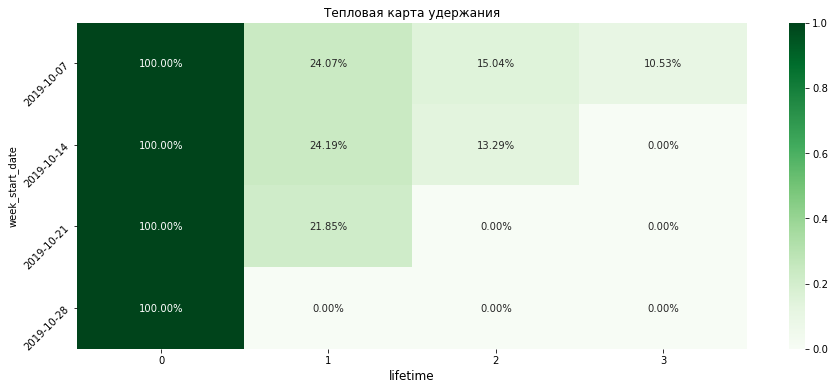

In [32]:
# строим хитмэп

plt.figure(figsize=(15, 6))  
sns.heatmap(
    result_grouped,  cmap="Greens",
    annot=True, 
    fmt='.2%',  
)
plt.title('Тепловая карта удержания')  
plt.yticks(rotation=45) 
plt.xlabel('lifetime', fontsize=12)
plt.show()

#### Вывод

По тепловой карте удержания видно, что значения удержания различаются для когорт, совершавших действия в разные недели
так например для когорты пользователей которые пришли 7-13 октября retention составил 24%, а для пользователей пришедших 21-27 октября retention составил 21.85%. У пользователей пришедших 14-20 октября retention практически совпадает с когортой 7-13 октября

### Время, проведенное в приложении

Для оценки времени, которое пользователи проводят в приложении для начала посмотрим метрику DAU - количество уникальных пользователей в день и метрику WAU -  количество уникальных пользователей в неделю

In [33]:
df['session_week'] = df['event_time_first'].dt.isocalendar().week
df['session_date'] = df['event_time_first'].dt.date
df['session_day'] = df['event_time'].dt.day
dau_total = (
    df.groupby('session_date').agg({'user_id': 'nunique'}).mean()
)
print('DAU:', int(dau_total))

DAU: 153


In [34]:
df['session_year'] = df['event_time_first'].dt.year
wau_total = (
    df.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)
print('WAU:', int(wau_total))

WAU: 1073


Количество уникальных пользователей в день равно 153, в месяц равно 1073

Теперь посмотрим на время, проведенное в приложении, для этого рассчитаем метрику ASL - средняя продолжительность сессии. 
Поскольку у многих пользователей были сессии в разные дни, то найдем время первого и последнего действия в сессии в группировке по дням

In [35]:
first_event_session = df.groupby(['user_id', 'session_day']).agg({'event_time': ['min', 'max']}).reset_index()
first_event_session.head()

user_id session_day          event_time  \
                                                                    min   
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           7 2019-10-07 13:39:46   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           9 2019-10-09 18:33:56   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          21 2019-10-21 19:52:31   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          22 2019-10-22 11:18:15   
4  00157779-810c-4498-9e05-a1e9e3cedf93           3 2019-11-03 17:12:10   

                       
                  max  
0 2019-10-07 13:49:42  
1 2019-10-09 18:42:23  
2 2019-10-21 20:07:30  
3 2019-10-22 11:30:53  
4 2019-11-03 17:12:10

In [36]:
first_event_session.columns = [''.join(col) for col in first_event_session.columns]

In [37]:
first_event_session

,user_id,session_day,event_timemin,event_timemax
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,7,2019-10-07 13:39:46,2019-10-07 13:49:42
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,9,2019-10-09 18:33:56,2019-10-09 18:42:23
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,21,2019-10-21 19:52:31,2019-10-21 20:07:30
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,22,2019-10-22 11:18:15,2019-10-22 11:30:53
4,00157779-810c-4498-9e05-a1e9e3cedf93,3,2019-11-03 17:12:10,2019-11-03 17:12:10
...,...,...,...,...
7812,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,26,2019-10-26 16:37:20,2019-10-26 17:35:06
7813,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,27,2019-10-27 14:46:59,2019-10-27 20:00:54
7814,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,28,2019-10-28 11:49:39,2019-10-28 15:15:51
7815,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,29,2019-10-29 13:58:48,2019-10-29 16:13:01


In [38]:
first_event_session['session_duration_sec'] = (
    first_event_session['event_timemax'] - first_event_session['event_timemin']
).dt.seconds
print('Среднее время всех сессий составляет', round(first_event_session['session_duration_sec'].mean()), 'c') 

Среднее время всех сессий составляет 4982 c


Среднее время сессий составляет 4982 секунды что примерно составляет 1 час 23 минуты. Посмотрим на среднее время по пользователям

In [39]:
user_session_duration = first_event_session.groupby('user_id').agg({'session_duration_sec': 
                        'mean'}).reset_index().sort_values(by='session_duration_sec', ascending=False)


Мы видим, что есть пользователи "победители" которые проводят в приложении по суткам (скорее всего просто много сессий в разные дни). Также есть пользователи чье время равно нулю, то есть какой-то случайный заход и может показ tips_show (это автоматическое действие) и затем выход

In [40]:
user_session_duration['session_duration_sec'].describe()

count     4293.000000
mean      3760.071225
std       7633.970067
min          0.000000
25%        368.000000
50%        987.000000
75%       3222.000000
max      84643.000000
Name: session_duration_sec, dtype: float64

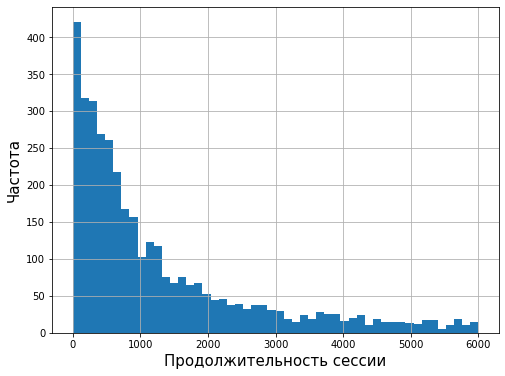

In [41]:
plt.figure(figsize=(8, 6))
user_session_duration['session_duration_sec'].hist(bins=50, range=(0, 6000))
plt.xlabel('Продолжительность сессии', fontsize = 15)
plt.ylabel('Частота', fontsize = 15)
plt.show()

Пик в районе нуля это нормально так как в любом цифровом сервисе очень многие сессии заканчиваются техническими ошибками. Посмотрим на медиану

In [42]:
print(user_session_duration['session_duration_sec'].median()) 

987.0


Медиана сильно меньше среднего значения, и составляет около 16 минут 45 секунд, кажется что это значение достаточно нормально, этого времени хватит чтобы зайти в приложение и выбрать товар, если ты знаешь что ищешь

#### Вывод

- Среднее время сессий составляет 4982 секунды что примерно составляет 1 час 23 минуты. Посмотрим на среднее время по пользователям
- Мы видим, что есть пользователи "победители" которые проводят в приложении по суткам (скорее всего просто много сессий в разные дни). Также есть пользователи чье время равно нулю это нормально так как в любом цифровом сервисе очень многие сессии заканчиваются техническими ошибками.
- Медиана сильно меньше среднего значения, и составляет около 16 минут 45 секунд, кажется что это значение достаточно нормально, этого времени хватит чтобы зайти в приложение и выбрать товар, если ты знаешь что ищешь

### частота действий


Для оценки частоты действий сначала оценим среднее число сессий на пользователя за неделю 

In [43]:
sessions_per_user = df.groupby(['session_year', 'session_week']).agg(
    {'user_id': ['count', 'nunique']}
)
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)       

sessions_per_user

n_sessions  n_users  sessions_per_user
session_year session_week                                        
2019         41                 24818     1130          21.962832
             42                 20572     1166          17.643225
             43                 17532     1094          16.025594
             44                 11275      903          12.486157

Мы видим что наибольшее количество сессий было в первую неделю, и дальше идет заметное уменьшение количества сессий

Теперь посмотрим количество действий в рамках отдельной сессии

In [44]:
event_session = df.groupby(['user_id', 'session_day']).agg({'event_time': ['min', 'max'], 'event_name':'count'}).reset_index()
event_session.head()

user_id session_day          event_time  \
                                                                    min   
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           7 2019-10-07 13:39:46   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           9 2019-10-09 18:33:56   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          21 2019-10-21 19:52:31   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          22 2019-10-22 11:18:15   
4  00157779-810c-4498-9e05-a1e9e3cedf93           3 2019-11-03 17:12:10   

                      event_name  
                  max      count  
0 2019-10-07 13:49:42          9  
1 2019-10-09 18:42:23          4  
2 2019-10-21 20:07:30         14  
3 2019-10-22 11:30:53          8  
4 2019-11-03 17:12:10          1

In [45]:
event_session.columns = [''.join(col) for col in event_session.columns]
event_session = event_session.sort_values(by='event_namecount', ascending = False)


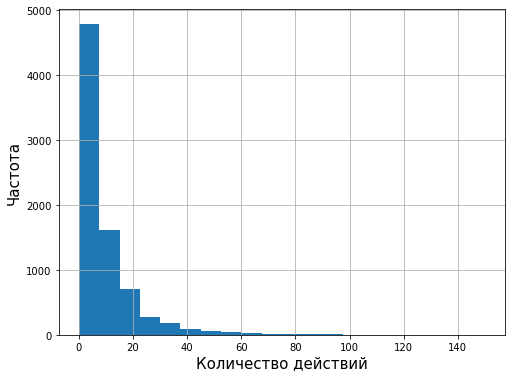

In [46]:
plt.figure(figsize=(8, 6))
event_session['event_namecount'].hist(bins = 20, range=(0, 150))
plt.xlabel('Количество действий', fontsize = 15)
plt.ylabel('Частота', fontsize = 15)
plt.show()

Мы видим, похожую на продолжительность сессий экспоненицальную зависимость, существуют как и аномально длинные сессии так и множество сессий с 1 действием

In [47]:
print(round(event_session['event_namecount'].mean(), 2))
print(round(event_session['event_namecount'].median(), 2))

9.49
6.0


#### Вывод 
Мы видим, похожую на продолжительность сессий экспоненицальную зависимость, существуют как и аномально длинные сессии так и множество сессий с 1 действием
Среднее количество действий за сессию 9.49, медианное 6

### Конверсия в целевое действие — просмотр контактов

Расчитаем общую конверсию - сколько было пользователей  и сколько просмотрело просмотр контактов (contacts_show). 

In [48]:
n_users = df['user_id'].value_counts().count()
n_users

4293

In [49]:
events_users = df.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
events_users

,event_name,user_id
8,tips_show,2801
6,search,1666
4,map,1456
5,photos_show,1095
2,contacts_show,981
0,advert_open,751
3,favorites_add,351
7,tips_click,322
1,contacts_call,213


In [50]:
print('Конверсия tips_show - contacts_show равна',  round((events_users['user_id'][2]/n_users)*100, 2), '%') 

Конверсия tips_show - contacts_show равна 22.85 %


#### Вывод 

Конверсия пользователей из действия просмотр рекомендованного объявления tips_show в просмотр контактов contacts_show равна 22.85 %

### Вывод

1. По тепловой карте удержания видно, что значения удержания различаются для когорт, совершавших действия в разные недели так например для когорты пользователей которые пришли 7-13 октября retention составил 24%, а для пользователей пришедших 21-27 октября retention составил 21.85%. У пользователей пришедших 14-20 октября retention практически совпадает с когортой 7-13 октября
2. Среднее время сессий составляет 4982 секунды что примерно составляет 1 час 23 минуты. Посмотрим на среднее время по пользователям Мы видим, что есть пользователи "победители" которые проводят в приложении по суткам (скорее всего просто много сессий в разные дни). Также есть пользователи чье время равно нулю это нормально так как в любом цифровом сервисе очень многие сессии заканчиваются техническими ошибками. Медиана сильно меньше среднего значения, и составляет около 16 минут 45 секунд, кажется что это значение достаточно нормально, этого времени хватит чтобы зайти в приложение и выбрать товар, если ты знаешь что ищешь
3. Мы видим, похожую на продолжительность сессий экспоненицальную зависимость частоты действий по сессиям, существуют как и аномально длинные сессии так и множество сессий с 1 действием Среднее количество действий за сессию 9.49, медианное 6
4. Конверсия пользователей из действия просмотр рекомендованного объявления tips_show в просмотр контактов contacts_show равна 22.85 %

## Сегментация пользователей

Сегментируем пользователей используя кластеризацию. Возьмем за признаки следующие параметры: продолжительность сессии и количество действий за сессию. Сегментируем на два класса с помощью алгоритма кластеризации K-means

In [51]:
event_session['session_duration_sec'] = (
    event_session['event_timemax'] - event_session['event_timemin']
).dt.seconds

In [52]:
user_id_event_sessions = event_session.groupby('user_id').agg({'event_namecount':'sum', 
                        'session_duration_sec':'sum'}).reset_index()


In [53]:
# стандартизация для датафрейма
X_sc = user_id_event_sessions.drop(['user_id'], axis=1)

In [54]:
event_session_columns_list = X_sc.columns
X_sc = StandardScaler().fit_transform(X_sc)
X_sc = pd.DataFrame(X_sc, columns = event_session_columns_list).astype('float64')

In [55]:
km = KMeans(n_clusters=3
            , random_state=0)
labels = km.fit_predict(X_sc)

In [56]:
user_id_event_sessions['clusters'] = labels
user_id_event_sessions['clusters'].value_counts()


0    3995
1     271
2      27
Name: clusters, dtype: int64

In [57]:
event_session = event_session.merge(user_id_event_sessions, on='user_id')

In [58]:
event_session = event_session.drop(['event_namecount_y',
                                                'session_duration_sec_y'], axis=1)

In [59]:
event_session.columns

Index(['user_id', 'session_day', 'event_timemin', 'event_timemax',
       'event_namecount_x', 'session_duration_sec_x', 'clusters'],
      dtype='object')

In [60]:
event_session = event_session.rename(columns={"event_namecount_x": "event_namecount",
                        "session_duration_sec_x": "session_duration_sec"})

In [61]:
user_id_event_sessions.groupby('clusters').mean()

,event_namecount,session_duration_sec
clusters,,
0,11.818523,4597.286108
1,77.487085,49615.804428
2,221.592593,264156.000000


In [62]:
user_id_event_sessions.groupby('clusters')['user_id'].count()

clusters
0    3995
1     271
2      27
Name: user_id, dtype: int64

Алгоритм K-means сегментировал пользователей на 3 класса:

0 класс:
- 3995 пользователей
- среднее количество действий около 12
- средняя продолжительность всех сессий  4597 секунд приблизительно  1.5 часа


1 класс:
- 26 пользователей
- среднее количество действий 224 
- средняя продолжительность всех сессийс  268000 секунд приблизительно 74 часа 


2 класс:
- 272 пользователя
- среднее количество действий 78
- средняя продолжительность всех сессий 50000 секунд приблизительно 13 часов

Добавим информацию о кластерах в основной датафрейм

In [63]:
clusters = user_id_event_sessions[['user_id', 'clusters']]

In [64]:
df_clusters = df.merge(clusters, on = 'user_id')

In [65]:
df_0 = df_clusters[df_clusters['clusters'] == 0]
df_1 = df_clusters[df_clusters['clusters'] == 1]
df_2 = df_clusters[df_clusters['clusters'] == 2]

### Retention rate по классам

Воспользуемся функцией get_retention

In [66]:
retention_0 = get_retention(df_0)

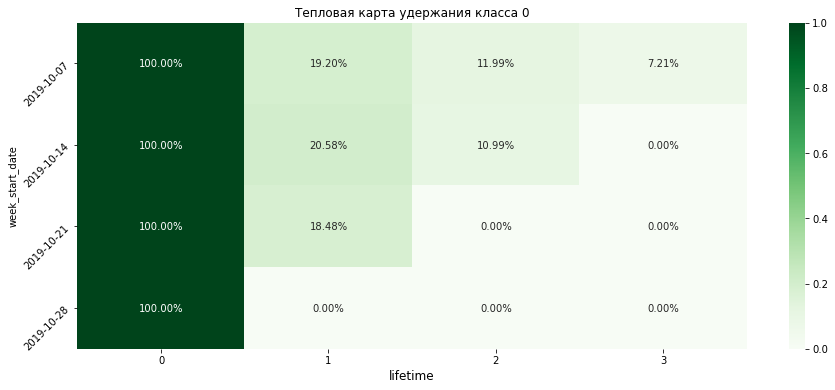

In [67]:
plt.figure(figsize=(15, 6))  
sns.heatmap(
    retention_0,  cmap="Greens",
    annot=True, 
    fmt='.2%',  
)
plt.title('Тепловая карта удержания класса 0')  
plt.yticks(rotation=45) 
plt.xlabel('lifetime', fontsize=12)
plt.show()

In [68]:
retention_1 = get_retention(df_1)

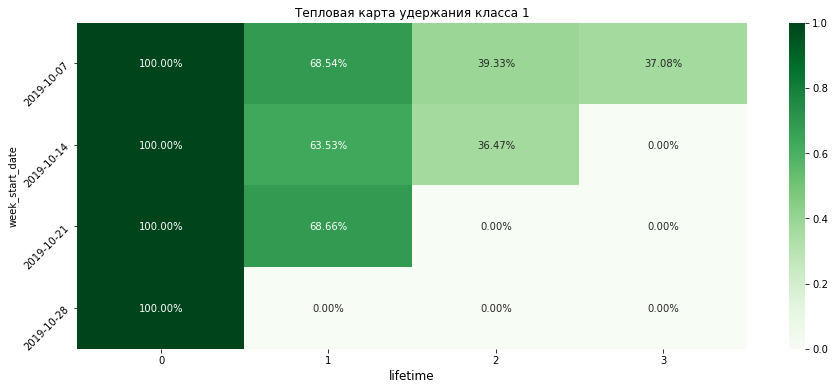

In [69]:
plt.figure(figsize=(15, 6))  
sns.heatmap(
    retention_1,  cmap="Greens",
    annot=True, 
    fmt='.2%',  
)
plt.title('Тепловая карта удержания класса 1')  
plt.yticks(rotation=45) 
plt.xlabel('lifetime', fontsize=12)
plt.show()

In [70]:
retention_2 = get_retention(df_2)

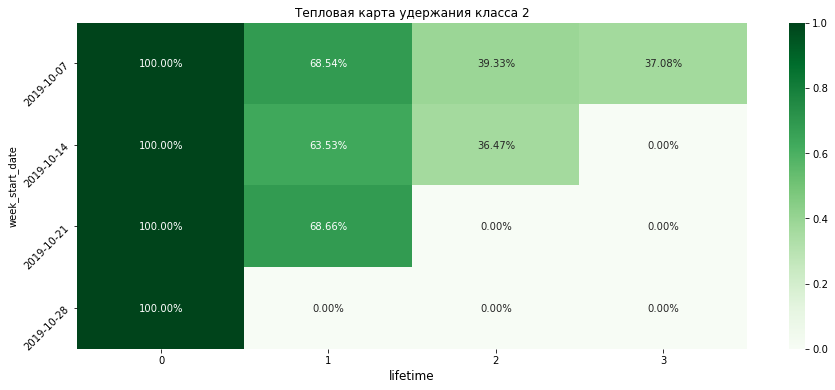

In [71]:
plt.figure(figsize=(15, 6))  
sns.heatmap(
    retention_1,  cmap="Greens",
    annot=True, 
    fmt='.2%',  
)
plt.title('Тепловая карта удержания класса 2')  
plt.yticks(rotation=45) 
plt.xlabel('lifetime', fontsize=12)
plt.show()

### Вывод

Мы видим что удержание у классов 1 и 2 не падает ниже 80 %, таким образом можно предположить что кластеризацией мы выделили группу аномально хороших пользователей, постоянно пользующихся данным приложением

### Конверсия

In [72]:
n_users_0 = df_0['user_id'].value_counts().count()
n_users_1 = df_1['user_id'].value_counts().count()
n_users_2 = df_2['user_id'].value_counts().count()

In [73]:
events_users_0 = df_0.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

print('Конверсия tips_show - contacts_show равна для класса 0 равна',  
      round((events_users_0['user_id'][2]/n_users_0)*100, 2), '%') 

Конверсия tips_show - contacts_show равна для класса 0 равна 20.7 %


In [74]:
events_users_1 = df_1.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

print('Конверсия tips_show - contacts_show равна для класса 1 равна',  
      round((events_users_1['user_id'][2]/n_users_1)*100, 2), '%') 

Конверсия tips_show - contacts_show равна для класса 1 равна 50.18 %


In [75]:
events_users_2 = df_2.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

print('Конверсия tips_show - contacts_show равна для класса 1 равна',  
      round((events_users_2['user_id'][2]/n_users_2)*100, 2), '%') 

Конверсия tips_show - contacts_show равна для класса 1 равна 66.67 %


 Конверсия для класса 0 составила 21 %, для классов 1  и 2 65% и 50%. Мы видим, что несмотря на аномально хорошее поведение пользователей класса 1 и 2  их вклад в конверсию не велик вследствие их маленького количества. 

### Время между ключевыми событиями

Посмотрим различаются ли попользователи классов на основе времени, которое проходит с момента первого использования мобильного приложения и до использования функции поиска

In [76]:
search_users_id = list(set(df[df['event_name'] == 'search']['user_id']))

In [77]:
# пользователи которые использовали поиск
search_users = df.query('user_id in @search_users_id')

In [78]:
# время первого взаимодействия и время первого поиска
search_time = search_users.query('event_name =="search"').groupby(['user_id']).agg({'event_time'
       :'min'}).sort_values(by='event_time').reset_index()

## объединяем и ищем разницу
min_time = search_users.groupby(['user_id']).agg({'event_time':'min'}).sort_values(by='event_time').reset_index()
search_time['first_event_time'] = min_time['event_time']
search_time['delta'] = (search_time['event_time'] - search_time['first_event_time']).astype('timedelta64[h]')


In [79]:
search_time_cluster = search_time.merge(user_id_event_sessions, how='left', on='user_id')

In [80]:
search_time_cluster = search_time_cluster.drop(['event_namecount', 'session_duration_sec'], axis=1)

In [81]:
search_time_cluster.groupby('clusters').agg({'delta':[min, max, np.mean]})

delta                 
           min   max       mean
clusters                       
0          0.0  32.0  14.911451
1          0.0  27.0  16.181208
2          5.0  24.0  14.466667

Мы видим что среднее количество времени, которое прошло от первого действия до поиска практически не отличается по кластерам и составляет около 15 часов для 0 кластера, 15 часов для первого и 16 для второго. Кажется что пользователи кластеров 1 и 2 которые - преданные проводят немного больше времени на моменте просмотра объявлений 

### Вывод

- Мы видим что удержание у классов 1 и 2 не падает ниже 80 %, таким образом можно предположить что кластеризацией мы выделили группу аномально хороших пользователей, постоянно пользующихся данным приложением

-  Конверсия для класса 0 составила 21 %, Для класса 1 и 2 65% и 50%. Мы видим, что несмотря на аномально хорошее поведение пользователей класса 1 и 2 их вклад в конверсию не велик вследствие их маленького количества.

- Мы видим что среднее количество времени, которое прошло от первого действия до поиска практически не отличается по кластерам и составляет около 16 часов для 0 кластера, 15 часов для первого и 17.5 для второго. Кажется что пользователи кластеров 1 и 2 которые - преданные проводят немного больше времени на моменте просмотра объявлений


## Проверка гипотез

### привлеченные по ссылке из yandex и по ссылке из google демонстрируют разную конверсию в просмотры контактов

- **Нулевая гипотеза** - конверсия в просмотры контактов одинаковая у пользователей, привлеченных из yandex и у пользователей, привлеченных из google
- **Альтернативная гипотеза** - конверсия в просмотры контактов разная у пользователей, привлеченных из yandex и у пользователей, привлеченных из google

Воспользуемся z тестом для проверки гипотезы

In [82]:
df_yandex = df[df['source'] == 'yandex'].groupby('event_name').agg({'user_id':
                                'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
df_google = df[df['source'] == 'google'].groupby('event_name').agg({'user_id':
                                'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [83]:
users_yandex = df[df['source'] == 'yandex']['user_id'].value_counts().count()
users_google = df[df['source'] == 'google']['user_id'].value_counts().count()

In [84]:

contacts_show = np.array([int(df_google[df_google['event_name'] == 'contacts_show']['user_id']),
                      int(df_yandex[df_yandex['event_name'] == 'contacts_show']['user_id'])]) #contacts_show	

users = np.array([users_google,
                      users_yandex]) #contacts_show	

In [85]:
z_test(contacts_show, users)

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Таким образом мы принимаем нулевую гипотезу **конверсия в просмотры контактов одинаковая у пользователей, привлеченных из yandex и у пользователей, привлеченных из google**

### пользователи с событием tips_click(пользователь кликнул по рекомендованному объявлению) и пользователи, использовавшие поиск search демонстрируют разную конверсию в добавление в избранное

In [86]:
tips_click = df.query('event_name == "tips_click"')
search = df.query('event_name == "search"')

In [87]:
# находим id пользователей которые совершили действия tips_click, search
tips_click_users = df[df['event_name'] == 'tips_click']['user_id'].value_counts().reset_index()['index']
search_users = df[df['event_name'] == 'search']['user_id'].value_counts().reset_index()['index']

In [88]:
# Находим сколько пользователей из тех, кто кликнул по рекомендованному объявлению, добавил в избранные
tips_click_favorite_ads = df.query('user_id in @tips_click_users and event_name == "favorites_add"').count()[0]

In [89]:
search_favorite_ads = df.query('user_id in @search_users and event_name == "favorites_add"').count()[0]

In [90]:
tips_click.count()[0]

814

In [91]:
users = [tips_click.count()[0], search.count()[0]]
favorite_ads = [tips_click_favorite_ads, search_favorite_ads]

In [92]:
z_test(favorite_ads, users)

p-значение:  7.566391957425367e-12
Отвергаем нулевую гипотезу: между долями есть значимая разница


Таким образом мы отвергаем нулевую гипотезу **конверсия добавление в избранное разная у пользователей, пользующихся search и у пользователей, пользующихся tips_click**

### Вывод
1. конверсия в просмотры контактов одинаковая у пользователей, привлеченных из yandex и у пользователей, привлеченных из google
2. конверсия добавление в избранное разная у пользователей, пользующихся search и у пользователей, пользующихся tips_click 

## Общий вывод

1. В ходе предобработки названия полей датафреймов были приведены к стилю snake_case, данные были проверены на пропуски и дубликаты, поле с датой было приведено к необходимому формату, из столбца с событиями были убраны неявные дубликаты, данные были объединены для последующей работы


2. В ходе исследовательского анализа было выяснено:
    - значения удержания различаются для когорт, совершавших действия в разные недели так например для когорты пользователей которые пришли 7-13 октября retention составил 24%, а для пользователей пришедших 21-27 октября retention составил 21.85%. У пользователей пришедших 14-20 октября retention практически совпадает с когортой 7-13 октября
    - Среднее время сессий составляет 4982 секунды что примерно составляет 1 час 23 минуты. Есть пользователи "победители" которые проводят в приложении по суткам (скорее всего просто много сессий в разные дни). Также есть пользователи чье время равно нулю это нормально так как в любом цифровом сервисе очень многие сессии заканчиваются техническими ошибками. Медиана сильно меньше среднего значения, и составляет около 16 минут 45 секунд.
    - Мы видим, похожую на продолжительность сессий экспоненицальную зависимость частоты действий по сессиям, существуют как и аномально длинные сессии так и множество сессий с 1 действием Среднее количество действий за сессию 9.49, медианное 6 Конверсия пользователей и в просмотр контактов contacts_show равна 22
    
3. Была произведена сегментация пользователей алгоритмом кластеризации, с количеством классов 3. Удержание у классов 1 и 2 не падает ниже 80 %, таким образом можно предположить что кластеризацией мы выделили две группы аномально хороших пользователей, постоянно пользующихся данным приложением. Конверсия для класса 0 составила 21 %, Для класса 1 и 2 65% и 50%. Мы видим, что несмотря на аномально хорошее поведение пользователей класса 1 и 2 их вклад в конверсию не велик вследствие их маленького количества. Среднее количество времени, которое прошло от первого действия до поиска практически не отличается по кластерам и составляет около 16 часов для 0 кластера, 15 часов для первого и 17.5 для второго. Кажется что пользователи кластеров 1 и 2 которые - преданные проводят немного больше времени на моменте просмотра объявлений


4. Мы проверили 2 гипотезы, в результате:
     - конверсия в просмотры контактов одинаковая у пользователей, привлеченных из yandex и у пользователей, привлеченных из google
     - конверсия добавление в избранное разная у пользователей, пользующихся search и у пользователей, пользующихся tips_click
    
5. В целом чаще возвращаться склонны преданные пользователи, с большим количеством сессий и действий за сессию. Эти же пользователи чаще делают действие в просмотр контактов. Для дальнейшего анализа хотелось бы остановиться на пользователях класса 0 и посмотреть как можно оптимизировать их путь приложения 